# <span> <font color='3A40A2'>Bayes babes - Knowing the data</font> </span>

Colab to study the data.


---

### Docs

- [Project Group 2 Main doc](https://docs.google.com/document/d/1ZA0-Z-GO-pYg_CeYRGAYFPBJxr1fF4K0PAReS_vPJt0/edit)
- [Laquitaine & Gardner, Neuron, 2018 - *A Switching Observer for Human Perceptual Estimation*](https://pubmed.ncbi.nlm.nih.gov/29290551/)

In [64]:
##importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from numpy import pi
import seaborn as sns
import sys
import os

from google.colab import drive
drive.mount('/content/drive')
py_file_location = "/content/drive/MyDrive/Colab Notebooks"
sys.path.append(os.path.abspath(py_file_location))

import utils
from utils import getSubjecBasicStats

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORTANT: The *utils* file will contain functions and methods to help us and in the same time, keep the colabs clean (less code).

This file is ours 😀

In [ ]:
# @title define functions

# circular statistics utils
# -------------------
def get_cartesian_to_deg(
    x: np.ndarray, y: np.ndarray, signed: bool
) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree

def get_deg_to_rad(deg: np.array, signed: bool):
    """convert angles in degree to radian
    Args:
        deg (np.array): angles in degree
        signed (bool): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_deg_to_rad
            radians = get_deg_to_rad(np.array([0, 90, 180, 270], True)
            Out: array([ 0., 1.57079633, 3.14159265, -1.57079633])
    Returns:
        np.ndarray: angles in radian
    """
    # get unsigned radians (1:2*pi)
    rad = (deg / 360) * 2 * pi

    # get signed radians(-pi:pi)
    if signed:
        rad[deg > 180] = (deg[deg > 180] - 360) * (
            2 * pi / 360
        )
    return rad

def get_polar_to_cartesian(
    angle: np.ndarray, radius: float, type: str
) -> dict:
    """convert angle in degree or radian to cartesian coordinates
    Args:
        angle (np.ndarray): angles in degree or radian
        radius (float): radius
        type (str): "polar" or "radian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_polar_to_cartesian
            degree = np.array([0, 90, 180, 270])
            cartesian = get_polar_to_cartesian(degree, 1, "polar")
            cartesian.keys()

            # Out: dict_keys(['deg', 'rad', 'cart'])

            cartesian["cart"]

            # Out: array([[ 1.,  0.],
            #            [ 0.,  1.],
            #            [-1.,  0.],
            #            [-0., -1.]])
    Returns:
        dict: _description_
    """
    # convert to radian if needed
    theta = dict()
    if type == "polar":
        theta["deg"] = angle
        theta["rad"] = angle * np.pi / 180
    elif type == "radian":
        theta["deg"] = get_deg_to_rad(angle, False)
        theta["rad"] = angle

    # convert to cartesian coordinates
    x = radius * np.cos(theta["rad"])
    y = radius * np.sin(theta["rad"])

    # round to 10e-4
    x = np.round(x, 4)
    y = np.round(y, 4)

    # reshape as (N angles x 2 coord)
    theta["cart"] = np.vstack([x, y]).T
    return theta

def get_circ_weighted_mean_std(
    angle: np.ndarray, proba: np.ndarray, type: str
) -> dict:
    """calculate circular data statistics
    Args:
        angle (np.ndarray): angles in degree or cartesian coordinates
        proba (np.ndarray): each angle's probability of occurrence
        type (str): "polar" or "cartesian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_circ_weighted_mean_std
            degree = np.array([358, 0, 2, 88, 90, 92])
            proba = np.array([1, 1, 1, 1, 1, 1])/6
            output = get_circ_weighted_mean_std(degree, proba, "polar")
            output.keys()
            # Out: dict_keys(['coord_all', 'deg_all', 'coord_mean', 'deg_mean',
            #               'deg_all_for_std', 'deg_mean_for_std', 'deg_var',
            #               'deg_std', 'deg_sem'])
            output["deg_mean"]
            # Out: array([45.])
            output["deg_std"]
            # array([45.02961988])
    Returns:
        (dict): angle summary statistics (mean, std, var, sem)

    Raises:
        ValueError: type is not "polar" or "cartesian"
    """

    angle = angle.copy()

    # if polar, convert to cartesian
    if type == "polar":
        radius = 1
        coord = get_polar_to_cartesian(
            angle, radius=radius, type="polar"
        )
    elif type == "cartesian":
        coord = angle
    else:
        raise ValueError(
            """ "type" can either be "polar" or "cartesian" value """
        )

    # store angles
    data = dict()
    data["coord_all"] = coord["cart"]
    data["deg_all"] = coord["deg"]

    # calculate mean
    # ..............
    proba_for_mean = np.tile(proba[:, None], 2)
    data["coord_mean"] = np.sum(
        proba_for_mean * data["coord_all"], 0
    )
    data["coord_mean"] = data["coord_mean"][:, None]
    data["deg_mean"] = get_cartesian_to_deg(
        data["coord_mean"][0],
        data["coord_mean"][1],
        signed=False,
    )

    # calculate std
    # ..............
    n_data = len(data["deg_all"])
    data["deg_all_for_std"] = data["deg_all"]
    data["deg_mean_for_std"] = np.tile(
        data["deg_mean"], n_data
    )

    # apply corrections
    # when 0 <= mean <= 180
    if data["deg_mean"] + 180 <= 360:
        for ix in range(n_data):
            if (
                data["deg_all"][ix]
                >= data["deg_mean"] + 180
            ):
                data["deg_all_for_std"][ix] = (
                    data["deg_all"][ix] - 360
                )
    else:
        # when 180 <= mean <= 360
        for ix in range(n_data):
            if (
                data["deg_all"][ix]
                <= data["deg_mean"] - 180
            ):
                data["deg_mean_for_std"][ix] = (
                    data["deg_mean"] - 360
                )

    # calculate variance, standard deviation and
    # standard error to the mean
    data["deg_var"] = np.array(
        [
            sum(
                proba
                * (
                    data["deg_all_for_std"]
                    - data["deg_mean_for_std"]
                )
                ** 2
            )
        ]
    )
    data["deg_std"] = np.sqrt(data["deg_var"])
    data["deg_sem"] = data["deg_std"] / np.sqrt(n_data)
    return data

def get_signed_angle(
    origin: np.ndarray, destination: np.ndarray, type: str
):
    """get the signed angle difference between origin and destination angles
    Args:
        origin (np.ndarray): origin angle
        destination (np.ndarray): destination angle
        type (str): angle type ("polar", "radian", "cartesian")
    Usage:
        .. code-block:: python
            angle = get_signed_angle(90, 45, 'polar')

            # Out: array([45.])

            angle = get_signed_angle(90, 45, 'radian')
            # Out: array([58.3103779])
            origin = np.array([[0, 1]])
            destination = np.array([[1, 0]])
            angle = get_signed_angle(origin, destination, "cartesian")

            # Out: array([90.])
    Returns:
        (np.ndarray): signed angle differences
    """

    # convert to cartesian coordinates
    if type == "polar" or type == "radian":
        origin_dict = get_polar_to_cartesian(
            origin, radius=1, type=type
        )
        destination_dict = get_polar_to_cartesian(
            destination, radius=1, type=type
        )
    elif type == "cartesian":
        origin_dict = dict()
        destination_dict = dict()
        origin_dict["cart"] = origin
        destination_dict["cart"] = destination

    # get coordinates
    xV1 = origin_dict["cart"][:, 0]
    yV1 = origin_dict["cart"][:, 1]
    xV2 = destination_dict["cart"][:, 0]
    yV2 = destination_dict["cart"][:, 1]

    # Calculate the angle separating the
    # two vectors in degrees
    angle = -(180 / np.pi) * np.arctan2(
        xV1 * yV2 - yV1 * xV2, xV1 * xV2 + yV1 * yV2
    )
    return angle

def get_combination_set(database: np.ndarray):
    """get the set of row combinations

    Args:
        database (np.ndarray): an N-D array

    Returns:
        (np.ndarray, np.ndarray, np.ndarray): `combs` is the set
        of combinations, `b` are the row indices for each combination
        in database, `c` are the rows indices for each combination in
        combs.
    """
    combs, ia, ic = np.unique(
        database,
        return_index=True,
        return_inverse=True,
        axis=0,
    )
    return (combs, ia, ic)

def get_data_stats(data: pd.Series, output: dict):
    """calculate data statistics

    Args:
        data (pd.Series): stimulus feature estimates
        output (dict): ::

            'PestimateGivenModel': estimate probabilities
            'map': max-a-posteriori percepts
            'conditions': task conditions

    Returns:
        (dict): returns data mean and std to output
    """
    # get conditions
    cond = output["conditions"]

    # initialise statistics
    data_mean = []
    data_std = []

    # get set of conditions
    cond_set, ix, _ = get_combination_set(cond)

    # record stats by condition
    for c_i in range(len(cond_set)):

        # find condition's instances
        loc_1 = cond[:, 0] == cond_set[c_i, 0]
        loc_2 = cond[:, 1] == cond_set[c_i, 1]
        loc_3 = cond[:, 2] == cond_set[c_i, 2]

        # get associated data
        data_c_i = data.values[loc_1 & loc_2 & loc_3]

        # set each instance with equal probability
        trial_proba = np.tile(
            1 / len(data_c_i), len(data_c_i)
        )

        # get statistics
        stats = get_circ_weighted_mean_std(
            data_c_i, trial_proba, type="polar",
        )

        # record statistics
        data_mean.append(stats["deg_mean"])
        data_std.append(stats["deg_std"])

    # record statistics
    output["data_mean"] = np.array(data_mean)
    output["data_std"] = np.array(data_std)

    # record their condition
    output["conditions"] = cond_set
    return output


# Visualization utils
# -------------------
def plot_mean(
    data_mean: np.ndarray,
    data_std: np.ndarray,
    condition: np.ndarray,
    prior_mode: float,
    centering: bool,
):
    """plot data and prediction mean and std
    for three conditions (x-axis, colors and panels)
    Args:
        data_mean (np.ndarray): data mean by condition
        data_std (np.ndarray): data std by condition
        prediction_mean (np.ndarray): prediction mean by condition
        prediction_std (np.ndarray): prediction std by condition
        condition (np.ndarray): associated conditions
        prior_mode (float): the mode of the prior
        centering (bool): center x-axis or not
    Returns:
        _type_: _description_
    """
    # get condition levels
    levels_1 = np.flip(np.unique(condition[:, 0]))
    levels_2 = np.flip(np.unique(condition[:, 1])) # sort in decreasing order
    levels_3 = np.unique(condition[:, 2])

    # set x_tick
    x_tick_centered = get_signed_angle(
        levels_1, prior_mode, "polar"
    )
    x_tick_centered[x_tick_centered == -180] = 180
    i_sort = np.argsort(x_tick_centered)
    x_tick_centered = x_tick_centered[i_sort]
    y_tick_centered = x_tick_centered

    # set colors
    levels_2_color = [
        [0.5, 0, 0],
        [1, 0.2, 0],
        [1, 0.6, 0],
        [0.75, 0.75, 0],
    ]

    plt.figure(figsize=(10,3))

    # loop over conditions and plot data
    # and prediction stats
    for level2_ix in range(len(levels_2)):

        # set condition 2 in column panels
        plt.subplot(1, len(levels_2), level2_ix + 1)

        # set condition 3 within panels
        for level1_ix in range(len(levels_1)):

            # find condition's instances
            loc_lev1 = (
                condition[:, 0] == levels_1[level1_ix]
            )
            loc_lev2 = (
                condition[:, 1] == levels_2[level2_ix]
            )
            loc_condition = loc_lev2 & loc_lev1

            # center to prior mode
            x_centered = condition[:, 2][loc_condition]
            if centering:
                x_centered = np.round(
                    get_signed_angle(
                        x_centered, prior_mode, "polar",
                    )
                )

            x_centered[x_centered == -180] = 180

            # make 2-D array
            x_centered = x_centered[:, None]

            # sort data stats
            y_data_centered = data_mean[loc_condition]
            y_data_std_centered = data_std[loc_condition]

            # sort all
            i_sort = np.argsort(x_centered.squeeze())
            x_centered = x_centered[i_sort]
            y_data_centered = y_data_centered[i_sort]
            y_data_std_centered = y_data_std_centered[
                i_sort
            ]

            # To plot estimates mean against circular stimulus
            # feature on a linear space, the raw stimulus feature and
            # estimates mean are normalized to vectorial angles from
            # the prior mode and x and y axes are centered at zero
            # (normalized prior mode) via a circular shift. Rotation
            # angles were then labelled according to their raw values
            # on the circle (e.g., 0, is labelled 225). A mean estimate
            # of 33 degree was calculated for 55 degree which is very far
            # from stimulus feature on the linear space but actually close
            # to stimulus feature on the circular space. We got rid of
            # this visual artifact by expressing both 55 and 33 as the
            # counterclockwise distance to prior mode (e.g., for a prior
            # mode 225 55 becomes 190 instead of 170 and 33 becomes 168).
            # Note that the maximum vectorial angle is >180.
            if (level2_ix == 3) & (not 180 in x_centered):

                # move point at -170? distance to prior at 190? (positive
                # side) and convert values at x=-170? to positive distance
                # relative to prior to improve visualization
                posNeg170 = x_centered == -170
                x_centered[posNeg170] = (
                    prior_mode - 170 + 360 - prior_mode
                )
                x_centered[x_centered == 180] = -180
                y_data_centered[posNeg170] = (
                    prior_mode
                    - abs(y_data_centered[posNeg170])
                    + 360
                    - prior_mode
                )

                # sort x-axis
                i_sort = np.argsort(x_centered)
                x_centered = x_centered[i_sort]

                # sort y-axis
                y_data_centered = y_data_centered[i_sort]

                # set ticks
                x_tick_centered = x_centered

            # plot data stats
            plt.errorbar(
                x_centered.squeeze(),
                y_data_centered.squeeze(),
                yerr=y_data_std_centered.squeeze(),
                marker="o",
                markersize=7,
                markeredgecolor="w",
                linestyle="None",
                linewidth=1,
                color=levels_2_color[level1_ix],
                ecolor=levels_2_color[level1_ix],
            )
            plt.ylim([-0, 360])
            plt.hlines(prior_mode, -180, 180, linestyle=':')
            plt.xticks([-160, -80, 0, 80, 160], [-160, -80, 0, 80, 160])
            plt.yticks([67, 147, 227, 307, 387], [-160, -80, 0, 80, 160])
            plt.xlabel("Motion direction distance" "\n" "relative to the prior mean" "\n" "(deg)")
            if level2_ix == 0:
              plt.ylabel("Mean estimates distance" "\n" "relative to the prior mean" "\n" "(deg)")
        plt.title(f"{int(levels_2[level2_ix]*100)}% coherence", fontsize=12)
    plt.show()
    return None

# Import the data

In [13]:
url = "https://github.com/steevelaquitaine/projInference/raw/gh-pages/data/csv/data01_direction4priors.csv"
try:
   RequestAPI = requests.get(url)
except requests.ConnectionError:
   print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
else:
   if RequestAPI.status_code != requests.codes.ok:
     print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
   else:
     with open("data01_direction4priors.csv", "wb") as fid:
       fid.write(RequestAPI.content)

In [67]:
data = pd.read_csv("drive/My Drive/School/phD/phD3/NeuroMatch/project/data01_direction4priors.csv")
data.head(30)

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id
0,1,0.000000,NaN,225,0.12,-1.749685,-1.785666,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
1,2,2.730730,NaN,225,0.12,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
2,3,4.913950,NaN,235,0.06,-1.562674,-1.951422,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
3,4,6.997296,NaN,225,0.06,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
4,5,9.097130,NaN,215,0.24,-1.639461,-1.887371,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
5,6,11.030394,NaN,205,0.24,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
6,7,13.080369,NaN,235,0.06,-1.713624,-1.820300,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
7,8,15.146855,NaN,215,0.12,-1.919213,-1.602068,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
8,9,17.163580,NaN,225,0.12,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
9,10,19.496723,NaN,225,0.12,-1.401729,-2.070062,NaN,NaN,10,225,1,data01_direction4priors,11,1,1


### Dataset info

`data` contains sessions from 12 human subjects, data from [Laquitaine & Gardner, 2018](https://doi.org/10.1016/j.neuron.2017.12.011).

Subjects had to estimate the direction of stimulus motion directions.

* `data['trial_index']`: trial index
* `data['trial_time']`: time at which trial starts with th e central fixation dot
* `data['response_arrow_start_angle']`: the angle of the response arrow at the start of the response phase.
* `data['motion_direction']`: the stimulus motion direction
* `data['motion_coherence']`: the stimulus motion coherence
* `data['estimate_x']`: x cartesian coordinate of the stimulus motion direction
* `data['estimate_y']`: y cartesian coordinate of the stimulus motion direction
* `data['reaction_time']`: subject's reaction time
* `data['raw_response_time']`: subject response time since the start of the run (of about 200 trials)
* `data['prior_std']`: It is the standard deviation of the statistical distribution (motion direction generative process over trials, which we call "experimental prior") from which we sampled the stimulus motion direction displayed in each trial.
* `data['prior_mean']`: the most frequently displayed motion direction. It is the mean of the statistical distribution (motion direction generative process over trials, which we call "experimental prior") from which we sampled the stimulus motion direction displayed in each trial.
* `data['subject_id']`: the id of the subject for which behavior was recorded.
* `data['experiment_name']`: the name of the experiment. This dataaset only contains the "data01_direction4priors" experiment in which subject underwent a task in which four motion direction were sampled from one of four priors with 10, 40, 60 and 80 degree standard deviations in each block of about 200 trials. The mean of the "experimental prior"  was fixed at 225 deg.
* `data['experiment_id']`: the id of the experiment.
* `data['session_id']`: the id of the session.
* `data['run_id']`: the id of the run. (=block)


The complete original dataset is stored in .mat files here: https://data.mendeley.com/datasets/nxkvtrj9ps/1.

In [68]:
# @title convert subject estimate cartesian coordinates to degrees
estimates_deg = get_cartesian_to_deg(data["estimate_x"].values, data["estimate_y"].values, False)
data['estimates_deg'] = np.round(estimates_deg)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83213 entries, 0 to 83212
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   trial_index                 83213 non-null  int64  
 1   trial_time                  83213 non-null  float64
 2   response_arrow_start_angle  51363 non-null  float64
 3   motion_direction            83213 non-null  int64  
 4   motion_coherence            83213 non-null  float64
 5   estimate_x                  83210 non-null  float64
 6   estimate_y                  83210 non-null  float64
 7   reaction_time               51358 non-null  float64
 8   raw_response_time           51358 non-null  float64
 9   prior_std                   83213 non-null  int64  
 10  prior_mean                  83213 non-null  int64  
 11  subject_id                  83213 non-null  int64  
 12  experiment_name             83213 non-null  object 
 13  experiment_id               832

The dataset has 83213 rows. Some columns have null or NaN values, like *response_arrow_start_angle*, *reaction_time* and *raw_response_time*.

Counting NaN values.

In [ ]:
print(data.isnull().sum())

trial_index                       0
trial_time                        0
response_arrow_start_angle    31850
motion_direction                  0
motion_coherence                  0
estimate_x                        3
estimate_y                        3
reaction_time                 31855
raw_response_time             31855
prior_std                         0
prior_mean                        0
subject_id                        0
experiment_name                   0
experiment_id                     0
session_id                        0
run_id                            0
dtype: int64


In [52]:
##Counting the amount of NaN values for each subject
##for the columns *response_arrow_start_angle*, *reaction_time* and *raw_response_time*
##and storing the results in a dictionary
missing_values = {}
cols = ['response_arrow_start_angle', 'reaction_time', 'raw_response_time']
for subject in data['subject_id'].unique():
    missing_values[subject] = data[data['subject_id'] == subject][cols].isnull().sum()

print(missing_values)

{1: response_arrow_start_angle    5325
reaction_time                 5326
raw_response_time             5326
dtype: int64, 2: response_arrow_start_angle    7877
reaction_time                 7877
raw_response_time             7877
dtype: int64, 3: response_arrow_start_angle    6175
reaction_time                 6175
raw_response_time             6175
dtype: int64, 4: response_arrow_start_angle    4801
reaction_time                 4801
raw_response_time             4801
dtype: int64, 5: response_arrow_start_angle    2552
reaction_time                 2552
raw_response_time             2552
dtype: int64, 6: response_arrow_start_angle    0
reaction_time                 0
raw_response_time             0
dtype: int64, 7: response_arrow_start_angle    2560
reaction_time                 2560
raw_response_time             2560
dtype: int64, 8: response_arrow_start_angle    2560
reaction_time                 2561
raw_response_time             2561
dtype: int64, 9: response_arrow_start_angle   



---


# Basic Data Exploration

 #### 1. Numbers of subjects

In [ ]:
##Numbers of subjects
n = data['subject_id'].nunique()
print(n)

12


#### 2. Numbers of trials

In [ ]:
data.columns

Index(['trial_index', 'trial_time', 'response_arrow_start_angle',
       'motion_direction', 'motion_coherence', 'estimate_x', 'estimate_y',
       'reaction_time', 'raw_response_time', 'prior_std', 'prior_mean',
       'subject_id', 'experiment_name', 'experiment_id', 'session_id',
       'run_id'],
      dtype='object')

In [34]:
##trials per subject
data.groupby(["subject_id"])[["trial_index"]].count()

,trial_index
subject_id,
1,8562
2,7877
3,9412
4,4801
5,5789
6,7553
7,5797
8,5797
9,8632


In [45]:
##trials per session per subject
pd.set_option('display.max_rows', None)
data.groupby(["subject_id", "session_id"])[["trial_index"]].count()

trial_index
subject_id session_id             
1          1                  1065
           2                  1065
           3                  1065
           4                  1065
           5                  1065
           6                  1079
           7                  1079
           8                  1079
2          1                  1065
           2                  1065
           3                  1065
           4                  1065
           5                  1065
           6                   852
           7                   850
           8                   850
3          1                  1065
           2                  1065
           3                  1065
           4                  1065
           5                  1065
           6                   850
           7                  1079
           8                  1079
           9                  1079
4          1                   852
           2                  1065
           3                   850
           4                  1065
           5                   969
5          1                   850
           2                   852
           3                   850
           4                  1079
           5                  1079
           6                  1079
6          1                  1079
           2                  1079
           3                  1079
           4                  1079
           5                  1079
           6                  1079
           7                  1079
7          1                   850
           2                   852
           3                   858
           4                  1079
           5                  1079
           6                  1079
8          1                   850
           2                   858
           3                   852
           4                  1079
           5                  1079
           6                  1079
9          1                  1079
           2                  1079
           3                  1079
           4                  1079
           5                  1079
           6                  1079
           7                  1079
           8                  1079
10         1                  1079
           2                  1079
           3                   876
           4                   853
           5                  1079
           6                  1079
11         1                  1079
           2                  1079
           3                  1079
           4                  1079
           5                  1079
           6                  1079
12         1                  1079
           2                  1079
           3                  1079
           4                  1079
           5                  1079
           6                  1079

In [51]:
# trials per condition
data.groupby(["prior_std", "motion_coherence"])[["trial_index"]].count()

trial_index
prior_std motion_coherence             
10        0.06                     8132
          0.12                     5596
          0.24                     2844
20        0.06                     8172
          0.12                     5925
          0.24                     2372
40        0.06                     7784
          0.12                     5803
          0.24                     2324
80        0.06                    16665
          0.12                    11589
          0.24                     6007

In [47]:
# check subject 1
sub01_data = data[(data["subject_id"]==1)][["subject_id", "trial_index", "session_id", "run_id", "prior_std", "motion_coherence", "motion_direction", "estimate_x", "estimate_y"]]

# count the number of trials by run and session
sub01_data.groupby(["subject_id", "session_id", "run_id", "prior_std", "motion_coherence"])[["trial_index"]].count()

trial_index
subject_id session_id run_id prior_std motion_coherence             
1          1          1      10        0.06                      107
                                       0.12                       73
                                       0.24                       33
                      2      80        0.06                      106
                                       0.12                       75
                                       0.24                       34
                      3      20        0.06                      107
                                       0.12                       75
                                       0.24                       33
                      4      40        0.06                      101
                                       0.12                       75
                                       0.24                       31
                      5      80        0.06                      106
                                       0.12                       75
                                       0.24                       34
           2          6      10        0.06                      107
                                       0.12                       73
                                       0.24                       33
                      7      20        0.06                      107
                                       0.12                       75
                                       0.24                       33
                      8      40        0.06                      101
                                       0.12                       75
                                       0.24                       31
                      9      80        0.06                      106
                                       0.12                       75
                                       0.24                       34
                      10     80        0.06                      106
                                       0.12                       75
                                       0.24                       34
           3          11     80        0.06                      106
                                       0.12                       75
                                       0.24                       34
                      12     10        0.06                      107
                                       0.12                       73
                                       0.24                       33
                      13     20        0.06                      107
                                       0.12                       75
                                       0.24                       33
                      14     40        0.06                      101
                                       0.12                       75
                                       0.24                       31
                      15     80        0.06                      106
                                       0.12                       75
                                       0.24                       34
           4          16     40        0.06                      101
                                       0.12                       75
                                       0.24                       31
                      17     80        0.06                      106
                                       0.12                       75
                                       0.24                       34
                      18     10        0.06                      107
                                       0.12                       73
                                       0.24                       33
                      19     20        0.06                      107
                                       0.12                       75
                                       0.24            

---
# Descriptive stats



#### 1. Plot the response error (true degree - estimate deg)

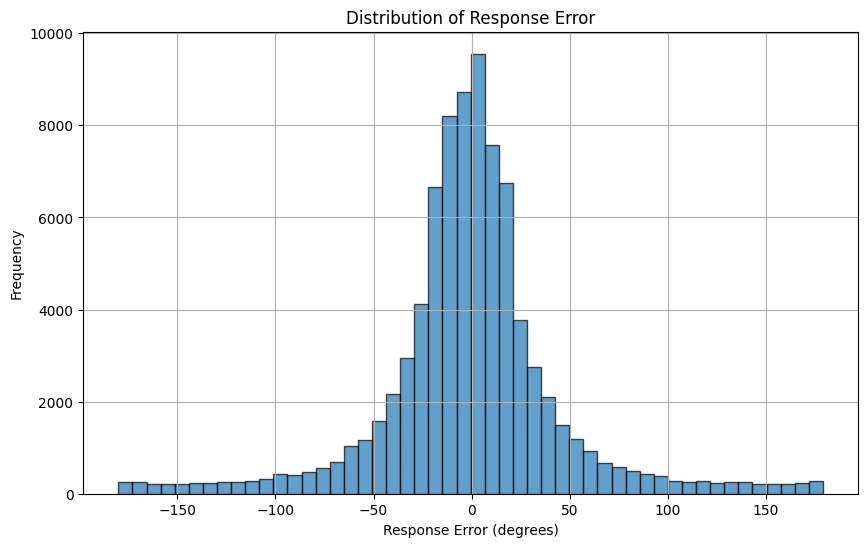

In [72]:
# make sure that the response_error stays within the range of -180 to 180 degrees
data['response_error'] = (data['motion_direction'] - data['estimates_deg'] + 180) % 360 - 180

plt.figure(figsize=(10, 6))
plt.hist(data['response_error'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Response Error')
plt.xlabel('Response Error (degrees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# plot the response error by co